In [1]:
from models.detector import FasterRCNN
from datasets import COCODataset
import torch
from torch.utils.data import DataLoader
import cv2
import os
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (20, 20)

In [2]:
faster_rcnn = FasterRCNN(81).cuda()
cocodataset = COCODataset('/home/zzy/Projects/Datasets/coco/annotations/instances_val2017.json', '/home/zzy/Projects/Datasets/coco/images/val2017')
loader = DataLoader(cocodataset, batch_size=1)

# faster_rcnn.eval()

	Unexpected key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [3]:
state_dict = torch.load('debug_rpn.pth')
faster_rcnn.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
for i, b in enumerate(loader):
    with torch.no_grad():
        faster_rcnn.eval()
#         proposals, pscores, obj_cls_losses, obj_reg_losses = faster_rcnn(b['img'].cuda(), b['img_meta'], b['gt_bboxes'].cuda(), b['gt_labels'].cuda())
        det_bboxes, det_labels = faster_rcnn(b['img'].cuda(), b['img_meta'], b['gt_bboxes'].cuda(), b['gt_labels'].cuda())
    print(b['img_meta'], b['img'][0].size())
    if i == 0:
        break

torch.Size([2000, 324])
{'scale_ratio': tensor([1.2500], dtype=torch.float64), 'img_size': tensor([[800., 534.]]), 'img_id': tensor([397133])} torch.Size([3, 534, 800])


In [5]:
img = cv2.imread(os.path.join(cocodataset.img_root, '%012d.jpg'%b['img_meta']['img_id'].item()), cv2.IMREAD_COLOR)

In [6]:
det_bboxes[0].shape

(24, 5)

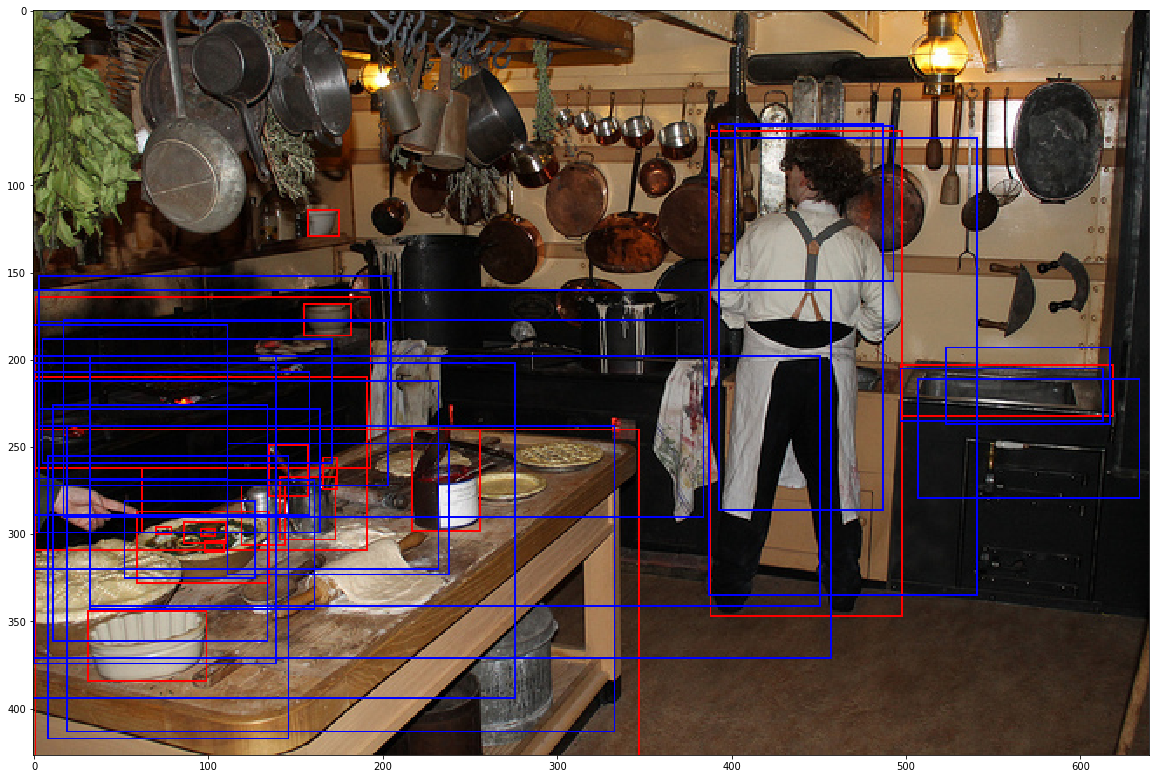

In [7]:
annids = cocodataset.coco.getAnnIds(imgIds=b['img_meta']['img_id'].item())
anns = cocodataset.coco.loadAnns(annids)

img_draw = img.copy()

for a in anns:
    bb = [i for i in a['bbox']]
#     b[0] -= b[2]/2
#     b[1] -= b[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img_draw = cv2.rectangle(img_draw, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (0, 0, 255), 1)
    
scale_ratio = b['img_meta']['scale_ratio'].item()
for p in det_bboxes[0]:
    bb = [i/scale_ratio for i in p[:-1]]
    bb[0] -= bb[2]/2
    bb[1] -= bb[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img_draw = cv2.rectangle(img_draw, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 0, 0))

pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img_draw[:, :, [2, 1, 0]])

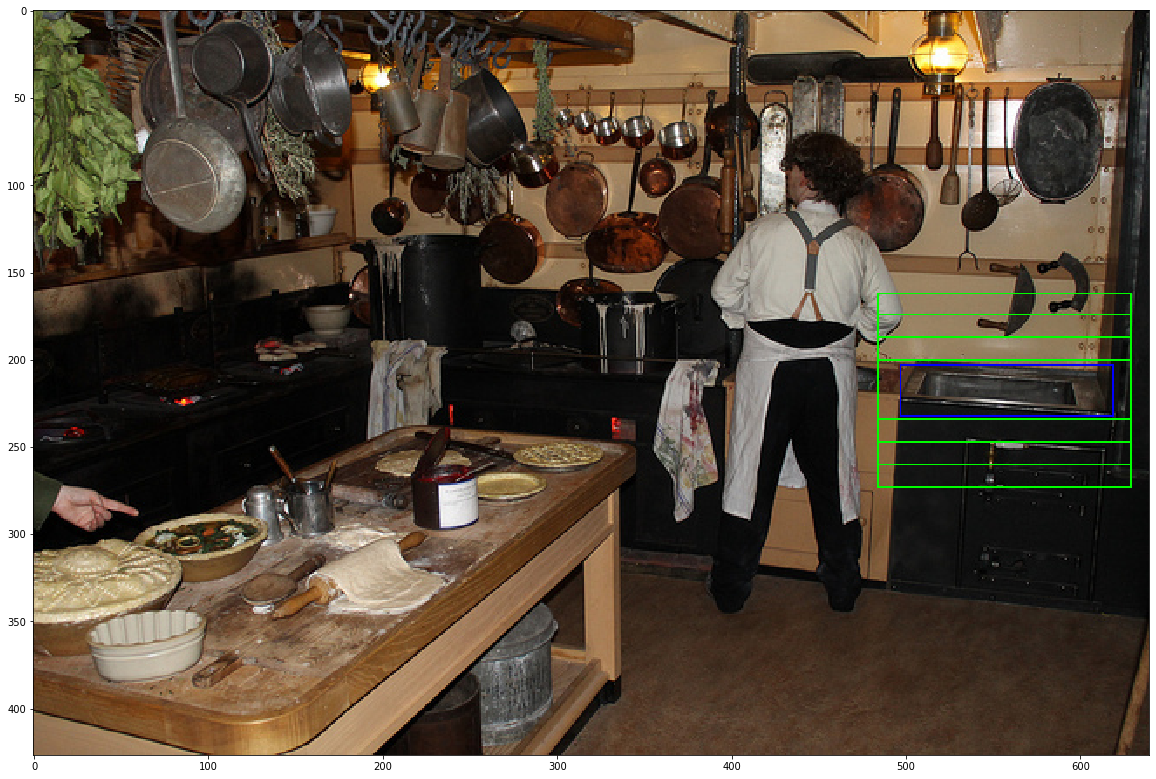

In [48]:
# debug assign result
img_assign = img.copy()

ind = 19

for ai, a in enumerate(anns):
    if ai != ind-1: continue
    bb = [i for i in a['bbox']]
#     b[0] -= b[2]/2
#     b[1] -= b[3]/2
    bb[2] += bb[0]
    bb[3] += bb[1]
    img_assign = cv2.rectangle(img_assign, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 0, 0), 1)

    
assign_results = torch.load('assign_results.pth')
scale_ratio = b['img_meta']['scale_ratio'].item()
for ani, an in enumerate(assign_results['anchors'].view(-1, 4)):
    if assign_results['assign_results'].view(-1)[ani] == ind:
        bb = [a.item()/scale_ratio for a in an]
        bb[0] -= bb[2]/2
        bb[1] -= bb[3]/2
        bb[2] += bb[0]
        bb[3] += bb[1]
        img_assign = cv2.rectangle(img_assign, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (0, 255, 0))
        
annids = cocodataset.coco.getAnnIds(imgIds=b['img_meta']['img_id'].item())
anns = cocodataset.coco.loadAnns(annids)
    
pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img_assign[:, :, [2, 1, 0]])

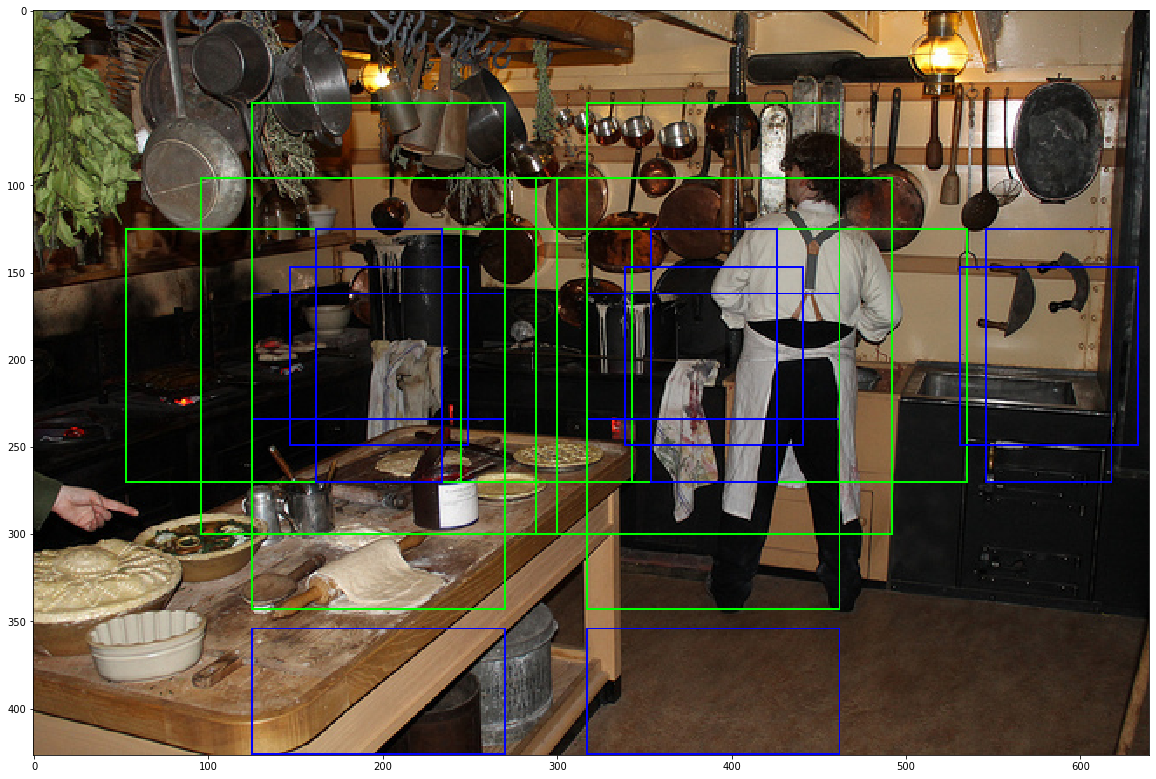

In [30]:
# debug anchor
anchors = torch.load('anchor.pth')
color_set = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

img_anchor = img.copy()
scale_ratio = b['img_meta']['scale_ratio'].item()
for bi, anchor_b in enumerate(anchors['anchors']):
    for wi, anchor_w in enumerate(anchor_b):
        if wi % 15 != 0: continue
        for hi, anchor_h in enumerate(anchor_w):
            if hi % 15 != 0: continue
            for si, anchor_s in enumerate(anchor_h):                
#                 if  si > 5: continue
#                 print([an.item()/scale_ratio for an in anchor_s])
                bb = [an.item()/scale_ratio for an in anchor_s]
                bb[0] -= bb[2]/2
                bb[1] -= bb[3]/2
                bb[2] += bb[0]
                bb[3] += bb[1]
                color = color_set[si%3]
                if anchors['anchors_ignore'][bi, wi, hi, si] == 0:
                    img_anchor = cv2.rectangle(img_anchor, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), color)
#                 else:
#                     img_anchor = cv2.rectangle(img_anchor, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (255, 255, 255))

pylab.rcParams['figure.figsize'] = (20, 20)
plt.imshow(img_anchor[:, :, [2, 1, 0]])